# Using OpenSTL in your own project

In this notebook, we will provide a comprehensive guide on how to use OpenSTL for your own project. 

Firstly, we will process video data into `.npy` format for easier storage and access. Next, we will demonstrate how to utilize custom data within OpenSTL. Subsequently, we will use OpenSTL to train and evaluate models. Finally, we will visualize predicted frames and generate `.gif` images or videos. 

- [1. Preprocess your data](#1-process-your-data)
    - [1.1 Save the dataset](#11-save-the-dataset)
    - [1.2 Load the dataset and visualize an example](#12-load-the-dataset-and-visualize-an-example)

- [2. Utilize cumtom data](#2-utilize-cumtom-data)
    - [2.1 Define the dataset](#21-define-the-dataset)
    - [2.2 Get the dataloaders](#22-get-the-dataloaders)

- [3. Train and evaluate](#3-train-and-evaluate)
    - [3.1 Define the custom configs](#31-define-the-custom-configs)
    - [3.2 Setup the experiment](#32-setup-the-experiment)
    - [3.3 Start training and evaluation](#33)

- [4. Visualization](#4-visualization)
    - [4.1 Visualize in a line](#41-visualize-in-a-line)
    - [4.2 Generate a GIF](#42-generate-a-gif)

Here we go!

## 1. Process your data

Assume you possess a collection of videos and have already sorted them into the `train/`, `val/`, and `test/` directories. The subsequent step involves transforming these videos into a `.pkl` file for further manipulations.

The existing file hierarchy is as follows:

- custom_usage.ipynb
- train
  - train_example1.avi
  - train_example2.avi
- val
  - val_example1.avi
  - val_example2.avi
- test
  - test_example.avi

It's crucial to note that the above example represents a simplified scenario where we've used `.avi` videos for illustrative purposes. However, in a real-world application, you are free to employ videos in various other formats.

We utilize several videos from the KTH dataset as examples. Although the original KTH dataset consists of single-channel grayscale videos, we save them as three-channel RGB videos to accommodate a broader range of use cases.

### 1.1 Save the dataset

Here, we default to uniformly sampling several frames from the given video data. The number of observed frames and future frames are two hyperparameters (`pre_seq_length`, `aft_seq_length`) that are set in advance. You can also choose to sample the video in other ways and save the data.

#### hyperparameters

`pre_seq_length`: the number of given frames

`aft_seq_length`: the number of frames to predict

In [1]:
pre_seq_length = 10
aft_seq_length = 20

In [2]:
import cv2
import numpy as np
import os

def sample_frames(video_path, num_frames=20):
    # read the video
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    # uniformly sample frames from the video
    frame_idxs = np.linspace(0, total_frames-1, num_frames, dtype=int)
    frames = []
    for idx in frame_idxs:
        video.set(cv2.CAP_PROP_POS_FRAMES, idx)
        _, frame = video.read()
        # frame = cv2.resize(frame, (height, width))
        frames.append(frame)
    video.release()
    return np.stack(frames)

def process_folder(folder_path, pre_slen=10, aft_slen=10, suffix='.avi'):
    # get all the videos in this folder
    videos = []
    files = os.listdir(folder_path)
    for file in files:
        video_path = os.path.join(folder_path, file)
        if os.path.isfile(video_path) and file.endswith(suffix):
            video = sample_frames(video_path, pre_slen + aft_slen)
            videos.append(video)
    # stack video frames from each folder
    data = np.stack(videos).transpose(0, 1, 4, 2, 3)

    # if the data is in [0, 255], rescale it into [0, 1]
    if data.max() > 1.0:
        data = data.astype(np.float32) / 255.0

    return data[:, :pre_slen], data[:, pre_slen:]

In [15]:
import pickle

dataset = {}
folders = ['train', 'val', 'test']
for folder in folders:
    data_x, data_y = process_folder(folder, pre_slen=pre_seq_length, aft_slen=aft_seq_length, suffix='.avi')
    dataset['X_' + folder], dataset['Y_' + folder] = data_x, data_y

# save as a pkl file
with open('dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

### 1.2 Load the dataset and visualize an example

In [4]:
import pickle

# load the dataset
# with open('dataset.pkl', 'rb') as f:
with open('./reformatedNDDs/dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
# print(dataset)
print(train_x.shape)
# the shape is B x T x C x H x W
# B: the number of samples
# T: the number of frames in each sample
# C, H, W: the channel, height, width of each frame

(5, 10, 1, 160, 280)


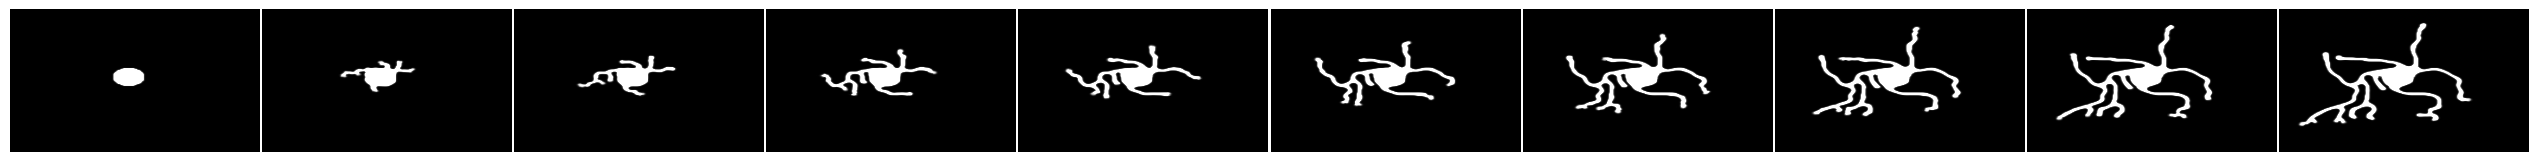

In [5]:
from openstl.utils import show_video_line

# show the given frames from an example
example_idx = 0
show_video_line(train_x[example_idx], ncols=pre_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

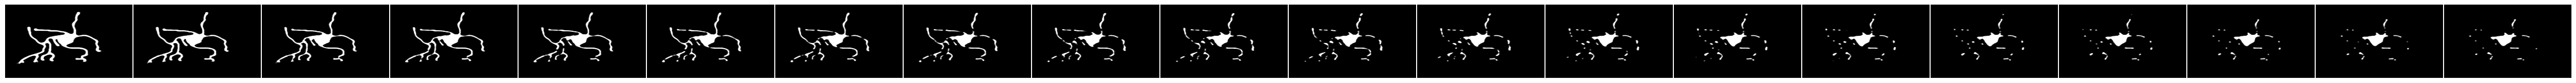

In [6]:
# show the future frames from an example
example_idx = 0
show_video_line(train_y[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

## 2. Utilize cumtom data

### 2.1 Define the dataset

We first define the `CustomDataset` to use the provided dataset. 

For real video prediction, to facilitate model optimization, we strongly recommend users to use frames represented as `float32` with values in the range of $[0, 1]$, rather than frames represented as `uint8` with values in the range of $[0, 255]$. For other types of data, we also provide the option to `normalize` in the `CustomDataset`.

In [7]:
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False, data_name='custom'):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None
        self.data_name = data_name

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

### 2.2 Get the dataloaders

Now we can get the dataloaders by using the collected dataset and the defined `CustomDataset`.

#### hyperparameters

`batch_size`: the size of a batch

In [8]:
batch_size = 1

In [9]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset[
    'X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)

In [10]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

## 3. Train and evaluate

### 3.1 Define the custom configs

We first define the training configuration, which includes several important hyperparameters for training.

Here, we set `epoch = 3` as an example for simple training. The actual value of epoch in your project depends on the complexity of your dataset. Generally, a good starting point is `epoch = 100`.

Next, we define the model configuration to customize a spatio-temporal predictive learning model. For MetaVP models, the key hyperparameters are: `N_S`, `N_T`, `hid_S`, `hid_T`, and `model_type`. Users have the option to either use a config file or directly set these hyperparameters.

If a config file is preferred, the user can simply include a `config_file` key with the path to the config file in the `custom_model_config` below. Otherwise, the user can directly specify these hyperparameters in the `custom_model_config`.

In [11]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 100,
    'lr': 0.001,   
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [10, 1, 32, 32],
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    # 'method': 'Modified_SimVP',
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py',
    
    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256
}

### 3.2 Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`. 

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [12]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)
# fulfill with default values
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test), strategy='auto')

/home/kuanrenqian/miniconda3/envs/OpenSTL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### 3.3 Start training and evaluation

With everything in place, we are now ready to start training and evaluation. 

Here we go!

In [13]:
torch.set_float32_matmul_precision('high')

print('>'*35 + ' training ' + '<'*35)
exp.train()

print('>'*35 + ' testing  ' + '<'*35)
exp.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<



  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | model     | SimVP_Model | 18.6 M | train
1 | criterion | MSELoss     | 0      | train
--------------------------------------------------
18.6 M    Trainable params
0         Non-trainable params
18.6 M    Total params
74.412    Total estimated model params size (MB)
215       Modules in train mode
0         Modules in eval mode


Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
CUDA available: True
CUDA_HOME: None
GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.4.0+cu121
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.1-Product Build 20220311 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.4.2 (Git Hash 1137e04ec0b5251ca2b4400a4fd3c667ce843d67)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch

Epoch 0, global step 5: 'val_loss' reached 0.05804 (best 0.05804), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=00-val_loss=0.058.ckpt' as top 1


Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s, v_num=21, train_loss_step=0.0641, train_loss_epoch=0.0634]

Epoch 1, global step 10: 'val_loss' reached 0.05548 (best 0.05548), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=01-val_loss=0.055.ckpt' as top 1


Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s, v_num=21, train_loss_step=0.0301, train_loss_epoch=0.0447]

Epoch 2, global step 15: 'val_loss' reached 0.03057 (best 0.03057), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=02-val_loss=0.031.ckpt' as top 1


Epoch 3: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s, v_num=21, train_loss_step=0.0241, train_loss_epoch=0.0288]

Epoch 3, global step 20: 'val_loss' reached 0.03034 (best 0.03034), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=03-val_loss=0.030.ckpt' as top 1


Epoch 4: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s, v_num=21, train_loss_step=0.0257, train_loss_epoch=0.0288]

Epoch 4, global step 25: 'val_loss' reached 0.02538 (best 0.02538), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=04-val_loss=0.025.ckpt' as top 1


Epoch 5: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s, v_num=21, train_loss_step=0.0149, train_loss_epoch=0.0213]

Epoch 5, global step 30: 'val_loss' reached 0.01885 (best 0.01885), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=05-val_loss=0.019.ckpt' as top 1


Epoch 6: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s, v_num=21, train_loss_step=0.0227, train_loss_epoch=0.0186]

Epoch 6, global step 35: 'val_loss' reached 0.01777 (best 0.01777), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=06-val_loss=0.018.ckpt' as top 1


Epoch 7: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s, v_num=21, train_loss_step=0.0176, train_loss_epoch=0.0166]

Epoch 7, global step 40: 'val_loss' reached 0.01527 (best 0.01527), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=07-val_loss=0.015.ckpt' as top 1


Epoch 8: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s, v_num=21, train_loss_step=0.0165, train_loss_epoch=0.0147]

Epoch 8, global step 45: 'val_loss' reached 0.01478 (best 0.01478), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=08-val_loss=0.015.ckpt' as top 1


Epoch 9: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s, v_num=21, train_loss_step=0.0154, train_loss_epoch=0.014] 

Epoch 9, global step 50: 'val_loss' reached 0.01364 (best 0.01364), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=09-val_loss=0.014.ckpt' as top 1


Epoch 10: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, v_num=21, train_loss_step=0.0105, train_loss_epoch=0.0131]

Epoch 10, global step 55: 'val_loss' reached 0.01268 (best 0.01268), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=10-val_loss=0.013.ckpt' as top 1


Epoch 11: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s, v_num=21, train_loss_step=0.0146, train_loss_epoch=0.0122]

Epoch 11, global step 60: 'val_loss' reached 0.01206 (best 0.01206), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=11-val_loss=0.012.ckpt' as top 1


Epoch 12: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s, v_num=21, train_loss_step=0.0124, train_loss_epoch=0.0113]

Epoch 12, global step 65: 'val_loss' reached 0.01108 (best 0.01108), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=12-val_loss=0.011.ckpt' as top 1


Epoch 13: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s, v_num=21, train_loss_step=0.00851, train_loss_epoch=0.0107]

Epoch 13, global step 70: 'val_loss' reached 0.01034 (best 0.01034), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=13-val_loss=0.010.ckpt' as top 1


Epoch 14: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s, v_num=21, train_loss_step=0.00765, train_loss_epoch=0.00963]

Epoch 14, global step 75: 'val_loss' reached 0.00945 (best 0.00945), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=14-val_loss=0.009.ckpt' as top 1


Epoch 15: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s, v_num=21, train_loss_step=0.00712, train_loss_epoch=0.00885]

Epoch 15, global step 80: 'val_loss' reached 0.00829 (best 0.00829), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=15-val_loss=0.008.ckpt' as top 1


Epoch 16: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s, v_num=21, train_loss_step=0.00637, train_loss_epoch=0.00794]

Epoch 16, global step 85: 'val_loss' reached 0.00764 (best 0.00764), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=16-val_loss=0.008.ckpt' as top 1


Epoch 17: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s, v_num=21, train_loss_step=0.0101, train_loss_epoch=0.00775]

Epoch 17, global step 90: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s, v_num=21, train_loss_step=0.00685, train_loss_epoch=0.00605]

Epoch 18, global step 95: 'val_loss' reached 0.00737 (best 0.00737), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=18-val_loss=0.007.ckpt' as top 1


Epoch 19: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s, v_num=21, train_loss_step=0.00737, train_loss_epoch=0.00669]

Epoch 19, global step 100: 'val_loss' reached 0.00624 (best 0.00624), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=19-val_loss=0.006.ckpt' as top 1


Epoch 20: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s, v_num=21, train_loss_step=0.00393, train_loss_epoch=0.00507]

Epoch 20, global step 105: 'val_loss' reached 0.00610 (best 0.00610), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=20-val_loss=0.006.ckpt' as top 1


Epoch 21: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s, v_num=21, train_loss_step=0.00525, train_loss_epoch=0.00481]

Epoch 21, global step 110: 'val_loss' reached 0.00597 (best 0.00597), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=21-val_loss=0.006.ckpt' as top 1


Epoch 22: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s, v_num=21, train_loss_step=0.0042, train_loss_epoch=0.00436]

Epoch 22, global step 115: 'val_loss' reached 0.00567 (best 0.00567), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=22-val_loss=0.006.ckpt' as top 1


Epoch 23: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s, v_num=21, train_loss_step=0.00417, train_loss_epoch=0.00376]

Epoch 23, global step 120: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s, v_num=21, train_loss_step=0.00364, train_loss_epoch=0.0038] 

Epoch 24, global step 125: 'val_loss' reached 0.00556 (best 0.00556), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=24-val_loss=0.006.ckpt' as top 1


Epoch 25: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s, v_num=21, train_loss_step=0.00338, train_loss_epoch=0.00345]

Epoch 25, global step 130: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s, v_num=21, train_loss_step=0.00349, train_loss_epoch=0.00331]

Epoch 26, global step 135: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s, v_num=21, train_loss_step=0.0042, train_loss_epoch=0.0032] 

Epoch 27, global step 140: 'val_loss' reached 0.00516 (best 0.00516), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=27-val_loss=0.005.ckpt' as top 1


Epoch 28: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s, v_num=21, train_loss_step=0.00287, train_loss_epoch=0.00391]

Epoch 28, global step 145: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s, v_num=21, train_loss_step=0.00298, train_loss_epoch=0.0029] 

Epoch 29, global step 150: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, v_num=21, train_loss_step=0.0019, train_loss_epoch=0.00244]

Epoch 30, global step 155: 'val_loss' reached 0.00511 (best 0.00511), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=30-val_loss=0.005.ckpt' as top 1


Epoch 31: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s, v_num=21, train_loss_step=0.00212, train_loss_epoch=0.00242]

Epoch 31, global step 160: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s, v_num=21, train_loss_step=0.00185, train_loss_epoch=0.00189]

Epoch 32, global step 165: 'val_loss' reached 0.00494 (best 0.00494), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=32-val_loss=0.005.ckpt' as top 1


Epoch 33: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s, v_num=21, train_loss_step=0.00196, train_loss_epoch=0.00174]

Epoch 33, global step 170: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, v_num=21, train_loss_step=0.00182, train_loss_epoch=0.00201]

Epoch 34, global step 175: 'val_loss' reached 0.00483 (best 0.00483), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=34-val_loss=0.005.ckpt' as top 1


Epoch 35: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s, v_num=21, train_loss_step=0.00215, train_loss_epoch=0.00188]

Epoch 35, global step 180: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s, v_num=21, train_loss_step=0.00169, train_loss_epoch=0.00196]

Epoch 36, global step 185: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s, v_num=21, train_loss_step=0.00133, train_loss_epoch=0.00178]

Epoch 37, global step 190: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s, v_num=21, train_loss_step=0.00141, train_loss_epoch=0.00205]

Epoch 38, global step 195: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, v_num=21, train_loss_step=0.0014, train_loss_epoch=0.00154]

Epoch 39, global step 200: 'val_loss' reached 0.00466 (best 0.00466), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=39-val_loss=0.005.ckpt' as top 1


Epoch 40: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s, v_num=21, train_loss_step=0.00157, train_loss_epoch=0.00128]

Epoch 40, global step 205: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s, v_num=21, train_loss_step=0.00118, train_loss_epoch=0.00134]

Epoch 41, global step 210: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s, v_num=21, train_loss_step=0.000931, train_loss_epoch=0.00148]

Epoch 42, global step 215: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s, v_num=21, train_loss_step=0.00176, train_loss_epoch=0.00139]

Epoch 43, global step 220: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s, v_num=21, train_loss_step=0.00117, train_loss_epoch=0.0012] 

Epoch 44, global step 225: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s, v_num=21, train_loss_step=0.000796, train_loss_epoch=0.0011]

Epoch 45, global step 230: 'val_loss' reached 0.00447 (best 0.00447), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=45-val_loss=0.004.ckpt' as top 1


Epoch 46: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s, v_num=21, train_loss_step=0.000749, train_loss_epoch=0.00106]

Epoch 46, global step 235: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, v_num=21, train_loss_step=0.000803, train_loss_epoch=0.001]  

Epoch 47, global step 240: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, v_num=21, train_loss_step=0.000987, train_loss_epoch=0.001]

Epoch 48, global step 245: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s, v_num=21, train_loss_step=0.000887, train_loss_epoch=0.000998]

Epoch 49, global step 250: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, v_num=21, train_loss_step=0.000685, train_loss_epoch=0.000928]

Epoch 50, global step 255: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s, v_num=21, train_loss_step=0.000871, train_loss_epoch=0.000879]

Epoch 51, global step 260: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s, v_num=21, train_loss_step=0.00136, train_loss_epoch=0.00104] 

Epoch 52, global step 265: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s, v_num=21, train_loss_step=0.000668, train_loss_epoch=0.00101]

Epoch 53, global step 270: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s, v_num=21, train_loss_step=0.000866, train_loss_epoch=0.00118]

Epoch 54, global step 275: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s, v_num=21, train_loss_step=0.000895, train_loss_epoch=0.00108]

Epoch 55, global step 280: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s, v_num=21, train_loss_step=0.000938, train_loss_epoch=0.000926]

Epoch 56, global step 285: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s, v_num=21, train_loss_step=0.000819, train_loss_epoch=0.000815]

Epoch 57, global step 290: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s, v_num=21, train_loss_step=0.000629, train_loss_epoch=0.000772]

Epoch 58, global step 295: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s, v_num=21, train_loss_step=0.000548, train_loss_epoch=0.000698]

Epoch 59, global step 300: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s, v_num=21, train_loss_step=0.000835, train_loss_epoch=0.000733]

Epoch 60, global step 305: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s, v_num=21, train_loss_step=0.000473, train_loss_epoch=0.000679]

Epoch 61, global step 310: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s, v_num=21, train_loss_step=0.00142, train_loss_epoch=0.000834]

Epoch 62, global step 315: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s, v_num=21, train_loss_step=0.000861, train_loss_epoch=0.000622]

Epoch 63, global step 320: 'val_loss' reached 0.00441 (best 0.00441), saving model to '/home/kuanrenqian/Research/OpenSTL/examples/work_dirs/custom_exp/checkpoints/best-epoch=63-val_loss=0.004.ckpt' as top 1


Epoch 64: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s, v_num=21, train_loss_step=0.000583, train_loss_epoch=0.000566]

Epoch 64, global step 325: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s, v_num=21, train_loss_step=0.000492, train_loss_epoch=0.000541]

Epoch 65, global step 330: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s, v_num=21, train_loss_step=0.000403, train_loss_epoch=0.000538]

Epoch 66, global step 335: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s, v_num=21, train_loss_step=0.000384, train_loss_epoch=0.000509]

Epoch 67, global step 340: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s, v_num=21, train_loss_step=0.000367, train_loss_epoch=0.000489]

Epoch 68, global step 345: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s, v_num=21, train_loss_step=0.000658, train_loss_epoch=0.000481]

Epoch 69, global step 350: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s, v_num=21, train_loss_step=0.000532, train_loss_epoch=0.000492]

Epoch 70, global step 355: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s, v_num=21, train_loss_step=0.000525, train_loss_epoch=0.000457]

Epoch 71, global step 360: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s, v_num=21, train_loss_step=0.000511, train_loss_epoch=0.000444]

Epoch 72, global step 365: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s, v_num=21, train_loss_step=0.000504, train_loss_epoch=0.000438]

Epoch 73, global step 370: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s, v_num=21, train_loss_step=0.000582, train_loss_epoch=0.000433]

Epoch 74, global step 375: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, v_num=21, train_loss_step=0.000504, train_loss_epoch=0.000429]

Epoch 75, global step 380: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s, v_num=21, train_loss_step=0.000328, train_loss_epoch=0.00042] 

Epoch 76, global step 385: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s, v_num=21, train_loss_step=0.000569, train_loss_epoch=0.000416]

Epoch 77, global step 390: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s, v_num=21, train_loss_step=0.000549, train_loss_epoch=0.000409]

Epoch 78, global step 395: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s, v_num=21, train_loss_step=0.000544, train_loss_epoch=0.00075] 

Epoch 79, global step 400: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s, v_num=21, train_loss_step=0.000316, train_loss_epoch=0.000411]

Epoch 80, global step 405: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s, v_num=21, train_loss_step=0.000489, train_loss_epoch=0.000408]

Epoch 81, global step 410: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s, v_num=21, train_loss_step=0.00031, train_loss_epoch=0.000401]

Epoch 82, global step 415: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s, v_num=21, train_loss_step=0.000307, train_loss_epoch=0.000442]

Epoch 83, global step 420: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s, v_num=21, train_loss_step=0.000534, train_loss_epoch=0.00046] 

Epoch 84, global step 425: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s, v_num=21, train_loss_step=0.000301, train_loss_epoch=0.000396]

Epoch 85, global step 430: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s, v_num=21, train_loss_step=0.000299, train_loss_epoch=0.000394]

Epoch 86, global step 435: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s, v_num=21, train_loss_step=0.00046, train_loss_epoch=0.00039] 

Epoch 87, global step 440: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s, v_num=21, train_loss_step=0.00052, train_loss_epoch=0.000389]

Epoch 88, global step 445: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s, v_num=21, train_loss_step=0.000455, train_loss_epoch=0.000387]

Epoch 89, global step 450: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s, v_num=21, train_loss_step=0.000453, train_loss_epoch=0.000384]

Epoch 90, global step 455: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s, v_num=21, train_loss_step=0.000355, train_loss_epoch=0.000383]

Epoch 91, global step 460: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s, v_num=21, train_loss_step=0.000515, train_loss_epoch=0.000386]

Epoch 92, global step 465: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s, v_num=21, train_loss_step=0.000296, train_loss_epoch=0.000384]

Epoch 93, global step 470: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s, v_num=21, train_loss_step=0.000296, train_loss_epoch=0.000381]

Epoch 94, global step 475: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s, v_num=21, train_loss_step=0.000513, train_loss_epoch=0.000382]

Epoch 95, global step 480: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s, v_num=21, train_loss_step=0.000292, train_loss_epoch=0.00038] 

Epoch 96, global step 485: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s, v_num=21, train_loss_step=0.000351, train_loss_epoch=0.00038]

Epoch 97, global step 490: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s, v_num=21, train_loss_step=0.000513, train_loss_epoch=0.00038]

Epoch 98, global step 495: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s, v_num=21, train_loss_step=0.000513, train_loss_epoch=0.000383]

Epoch 99, global step 500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s, v_num=21, train_loss_step=0.000513, train_loss_epoch=0.000383]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


## Visualization

By employing the `show_video_line` and `show_video_gif_multiple` functions provided by `OpenSTL`, we can visualize the input, ground truth, and predicted frames, as well as generate corresponding GIFs.

### 4.1 Visualize in a line

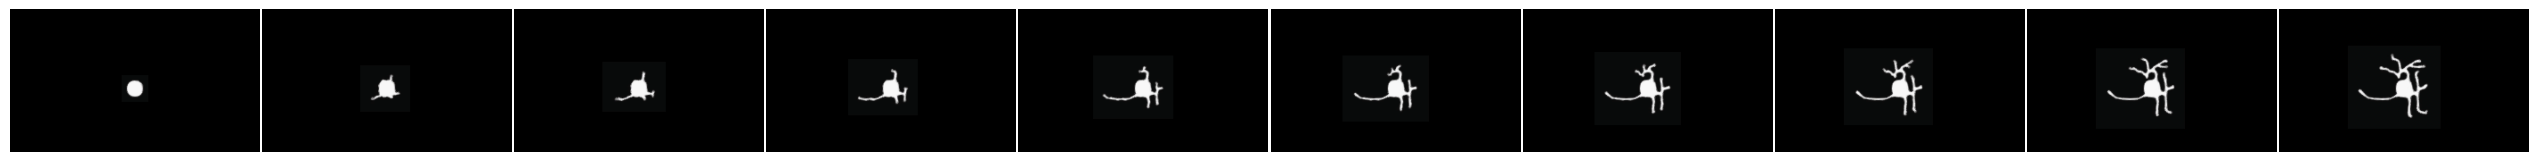

In [12]:
import numpy as np
from openstl.utils import show_video_line

# show the given frames from an example
inputs = np.load('./work_dirs/custom_exp/saved/inputs.npy')
preds = np.load('./work_dirs/custom_exp/saved/preds.npy')
trues = np.load('./work_dirs/custom_exp/saved/trues.npy')

example_idx = 0
show_video_line(inputs[example_idx], ncols=10, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11317378..1.5151644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08288699..1.4554789].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07283413..1.556396].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09622894..1.5144044].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07880516..1.6966962].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06591236..1.5865996].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056465052..1.5244821].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.082924195..1.501434].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07538981..1.4944212].


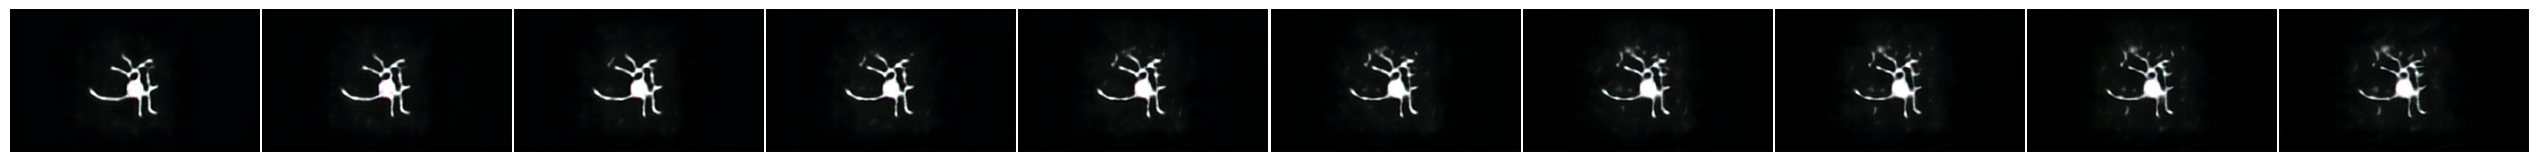

In [10]:
example_idx = 0
show_video_line(preds[example_idx], ncols=10, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

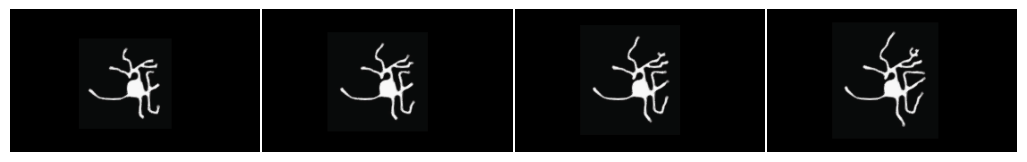

In [11]:
example_idx = 0
show_video_line(trues[example_idx], ncols=4, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

### 4.2 Generate a GIF

In [ ]:
from openstl.utils import show_video_gif_multiple

example_idx = 0
show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], use_rgb=False, out_path='example.gif')